In [1]:
import pandas               as pd
import matplotlib.pyplot    as plt
import numpy                as np
import glob
import random

training_image_path = 'datasets/training/'
training_tnf_csv    = 'training_data/tps'

train_pd = pd.read_csv(training_tnf_csv + '/train.csv') 

/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_25794/890084441.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd = transforms_pd.append({
/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_25794/890084441.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd = transforms_pd.append({
/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_25794/890084441.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd = transforms_pd.append({
/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_25794/890084441.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd = tra

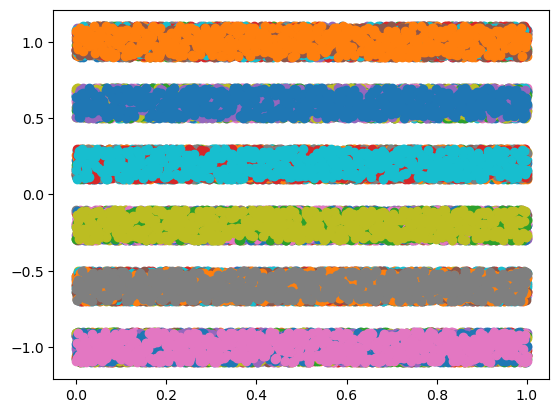

In [2]:
transforms_pd = pd.DataFrame(columns=['Parameter','Min','Max'])

# Find the min & max values of each parameter
for i in range(1,73):
    name = 't' + str(i)
    data = train_pd[name]
    plt.scatter(np.linspace(0, 1, len(data)), data)
    
    transforms_pd = transforms_pd.append({
        'Parameter': name, 
        'Min':       np.amin(data), 
        'Max':       np.amax(data)    
        }, ignore_index=True)
    

In [3]:
def random_transform(pd='', image_name='', min_max=[], name=True):
    """
    Create a random transform by sampling from each parameter. 
    Assume a uniform distribution between min & max values.
    """
    
    output = {}
    if name:
        output['ImageA'] = image_name
        output['ImageB'] = image_name
        
    if len(min_max):
        for i in range(1,19):
            name    = 't' + str(i)
            value   = np.random.uniform(min_max[0,i-1], min_max[1,i-1])
            output[name] = [value]
            
    else:
        for i in range(1,73):
            name    = 't' + str(i)
            row     = pd[pd['Parameter']==name]
            value   = np.random.uniform(row['Min'], row['Max'])[0]
            output[name] = [value]
            
    
        
    return output

### Add MRI images

In [21]:
file_names = ['HMU_003_DB', 'HMU_011_MQ', 'HMU_025_SH']

in_vivo = {
    'HMU_003_DB': [20,19,12],
    'HMU_007_TN': [19,18,16],
    'HMU_010_FH' : [19,17,13,12],
    'HMU_011_MQ': [18,12,10,9],
    'HMU_025_SH': [22,19,15]
}

updated_train_pd = train_pd.copy()
number_samples   = 0

for name in file_names:
    # MRI 
    mri_slices = in_vivo[name]
    for slice in mri_slices:
        image_name  = 'mri_' + name + '_' + str(slice) + '.png'
        new_row     = random_transform(transforms_pd, image_name)
        
        new_row_pd       = pd.DataFrame.from_dict(new_row)
        updated_train_pd = pd.concat((updated_train_pd, new_row_pd), ignore_index=True)
        
        number_samples += 1

### Add histology images

In [22]:
file_names = ['HMU_003_DB', 'HMU_011_MQ', 'HMU_025_SH','HMU_056_JH','HMU_060_CH','HMU_063_RS','HMU_064_SB','HMU_065_RH','HMU_067_MS']

updated_train_pd = train_pd.copy()
number_samples   = 0

histo = {
    'HMU_003_DB': ['_A1', '_A2','_A3','_A5'],
    'HMU_011_MQ': ['_4','_5','_6','_7','_8','_9'],
    'HMU_025_SH': ['A1','A3','A4','A5'],
    'HMU_056_JH': ['A1','A2','A3','A4','A5','A6'], 
    'HMU_060_CH': ['A1','A2','A3','A4','A5','A6'], 
    'HMU_063_RS': ['A1','A2','A3','A4','A5'], 
    'HMU_064_SB': ['A1','A4','A6'], 
    'HMU_065_RH': ['A1','A2','A3','A4','A5','A6'], 
    'HMU_067_MS': ['A1','A2','A3','A4','A5','A6','A7']
}

for i in range(10):
    for name in file_names: 
        histo_slices = histo[name]
        for slice in histo_slices:
            image_name  = name + str(slice) + '_segmented.png'
            new_row     = random_transform(transforms_pd, image_name)
            
            new_row_pd       = pd.DataFrame.from_dict(new_row)
            updated_train_pd = pd.concat((updated_train_pd, new_row_pd), ignore_index=True)
            
            number_samples += 1

print(number_samples)
updated_train_pd

updated_train_pd.to_csv('training_data/tps/train_updated_47.csv', index=False)

470


### Illustrate TPS transforms 

In [3]:
from process_img import * 
from geotnf.transformation import GeometricTnf
from skimage import io


def tps_transform_grid(transforms_pd):
    """
    Apply a random TPS transform to the sample grid
    """
    
    transform = random_transform(transforms_pd, name=False)
    theta_tps = [transform[i] for i in transform]
    theta_tps = torch.Tensor(np.transpose(theta_tps))

    # Preprocess image 
    source_image = io.imread('../Dataset/Data/grid.png')
    source_image = np.squeeze(source_image[:,:,:3])
    source_image[source_image<250] = 0
    source_image = process_image(source_image,use_cuda=False, out_size=1024)

    # TPS transformation
    tpsTnf       = GeometricTnf(geometric_model='tps', out_h=400, out_w=400, use_cuda=False)
    warped_image = tpsTnf(source_image,theta_tps)
        
    # Un-normalize images and convert to numpy
    warped_image_np = normalize_image(warped_image,forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
        
    # Ignore negative values
    warped_image_np[warped_image_np < 0] = 0    
    source_image = source_image.permute(0,2,3,1)
    return source_image, warped_image_np

In [6]:
source_image, warped_image = tps_transform_grid(transforms_pd)

fig, axs = plt.subplots(1,2)
axs[0].imshow(np.squeeze(source_image))
axs[1].imshow(warped_image)

NameError: name 'random_transform' is not defined

In [12]:
from process_img import * 
from geotnf.transformation import GeometricTnf
from skimage import io
from torch.nn.functional import normalize

def tps_Grid(theta_tps, norm=False):
    """
    Apply a random TPS transform to the sample grid
    """
    
    theta_tps = torch.Tensor(theta_tps)
    if norm:
        theta_tps = normalize(theta_tps)

    # Preprocess image 
    source_image = io.imread('../Dataset/Data/grid.png')
    source_image = np.squeeze(source_image[:,:,:3])
    source_image[source_image<250] = 0
    source_image = process_image(source_image, use_cuda=False, out_size=1024)

    # TPS transformation
    tpsTnf_mri   = GeometricTnf(geometric_model='tps-mri', out_h=400, out_w=400, use_cuda=False)
    warped_image = tpsTnf_mri(source_image,theta_tps)
        
    # Un-normalize images and convert to numpy
    warped_image_np = normalize_image(warped_image,forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
        
    # Ignore negative values
    warped_image_np[warped_image_np < 0] = 0    
    source_image = source_image.permute(0,2,3,1)
    
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(np.squeeze(source_image))
    axs[1].imshow(warped_image_np)

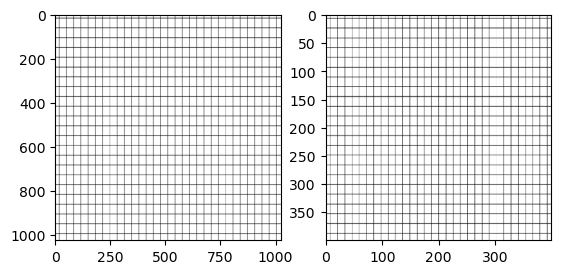

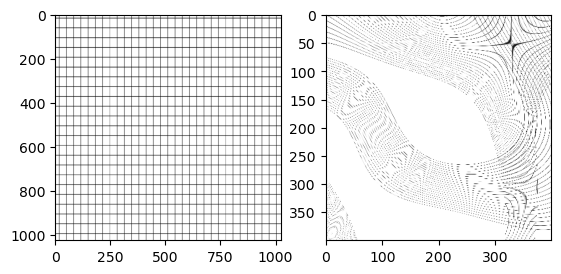

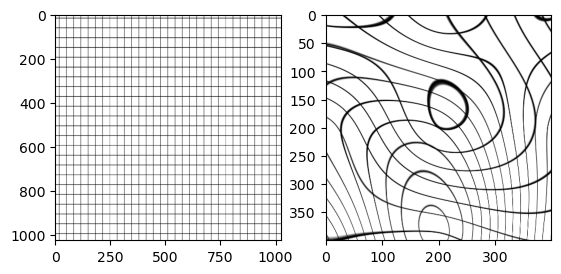

In [13]:
tps =[
            [
                -0.6362779140472412,
                -1.6981632709503174,
                0.587742805480957,
                0.8616968393325806,
                -2.4061849117279053,
                -4.045632839202881,
                -0.05718374252319336,
                1.5738213062286377,
                1.9545316696166992,
                -2.3466782569885254,
                1.491770625114441,
                1.8796687126159668,
                -1.5033074617385864,
                -2.048987865447998,
                2.108168601989746,
                0.7781451940536499,
                -0.4112209379673004,
                1.1588855981826782
            ]
        ]
tps_test =[[-1.0,-1.0,-1.0,0.0,0.0,0.0,1.0,1.0,1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,-1.0,0.0,1.0]]

tps_Grid(tps_test)
tps_Grid(tps)
tps_Grid(tps, norm=True)

/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


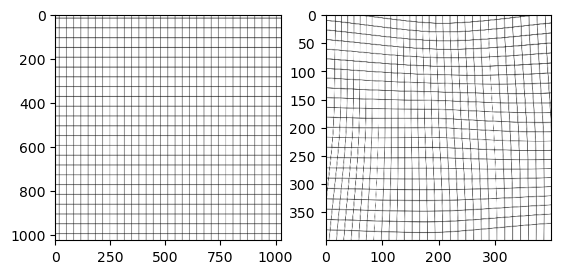

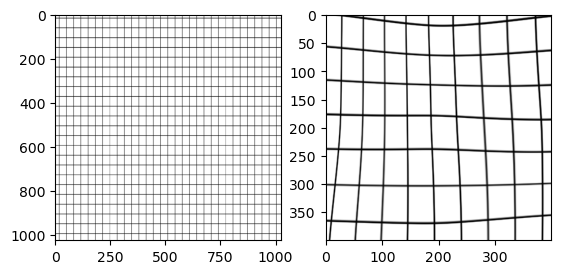

In [15]:
min_max = [[-1.1, -1.1, -1.1, -0.1, -0.1, -0.1, 0.9, 0.9, 0.9,-1.1, -0.1, 0.9,-1.1, -0.1, 0.9,-1.1, -0.1, 0.9],
            [-0.9, -0.9, -0.9, 0.1,  0.1,  0.1, 1.1, 1.1, 1.1,-0.9, 0.1, 1.1,-0.9, 0.1, 1.1,-0.9, 0.1, 1.1]]
min_max = np.array(min_max)

tps = []
for i in range(18):
    tps.append(np.random.uniform(min_max[0,i], min_max[1,i]))
tps = [tps]

tps_Grid(tps)
tps_Grid(tps, norm=True)


### MRI training data

In [ ]:
columns = ['ImageA','ImageB']
for i in range(1,73):
    columns.append('t' + str(i))
    
train_mri_pd = pd.DataFrame(columns=columns)
test_mri_pd  = pd.DataFrame(columns=columns)

number_samples   = 0

file_names =  [i[20:] for i in sorted(glob.glob('./datasets/training/mri_*'))]

for i in range(10):
    count = 0
    for name in file_names: 
        new_row     = random_transform(transforms_pd, name)
        new_row_pd  = pd.DataFrame.from_dict(new_row)
        
        if count < 61:
            train_mri_pd = pd.concat((train_mri_pd, new_row_pd), ignore_index=True)
        else:
            test_mri_pd  = pd.concat((test_mri_pd, new_row_pd), ignore_index=True)
    
        number_samples += 1
        count          += 1

print(number_samples)
train_mri_pd.to_csv('training_data/tps/mri_train.csv', index=False)
test_mri_pd.to_csv('training_data/tps/mri_test.csv', index=False)
test_mri_pd


820


,ImageA,ImageB,t1,t2,t3,t4,t5,t6,t7,t8,...,t63,t64,t65,t66,t67,t68,t69,t70,t71,t72
0,mri_TCIA-0021_09.jpg,mri_TCIA-0021_09.jpg,-1.008367,-1.054707,-0.942675,-0.968491,-1.049444,-0.924799,-0.659288,-0.542270,...,-0.147489,0.260593,0.612017,1.079344,-1.036750,-0.690782,-0.226243,0.274781,0.628379,1.002083
1,mri_TCIA-0021_10.jpg,mri_TCIA-0021_10.jpg,-0.996976,-0.956464,-1.028766,-1.083395,-0.943323,-1.002217,-0.679270,-0.552192,...,-0.288744,0.100280,0.651726,0.954001,-0.900413,-0.565001,-0.138385,0.103915,0.631452,0.977195
2,mri_TCIA-0021_11.jpg,mri_TCIA-0021_11.jpg,-1.092360,-1.044288,-0.914137,-1.030593,-0.972014,-1.069282,-0.670937,-0.571004,...,-0.260032,0.203843,0.669532,1.074024,-0.936722,-0.677353,-0.154561,0.245882,0.568576,0.991508
3,mri_TCIA-0021_12.jpg,mri_TCIA-0021_12.jpg,-1.005393,-1.022066,-1.018239,-1.026573,-0.960166,-0.938544,-0.550997,-0.652634,...,-0.126175,0.227872,0.697144,0.916429,-1.065591,-0.501847,-0.253359,0.215503,0.685727,1.023440
4,mri_TCIA-0021_13.jpg,mri_TCIA-0021_13.jpg,-1.070546,-0.941964,-1.061482,-1.058674,-1.071907,-1.024241,-0.625985,-0.524939,...,-0.220528,0.173528,0.510662,1.018361,-0.936542,-0.522919,-0.110605,0.273816,0.597664,0.981572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,mri_TCIA-0025_11.jpg,mri_TCIA-0025_11.jpg,-1.066310,-0.961148,-0.988854,-1.035713,-1.006756,-1.076686,-0.531722,-0.572219,...,-0.142655,0.133049,0.578103,0.958442,-0.932310,-0.638003,-0.166703,0.110212,0.659319,1.072591
206,mri_TCIA-0025_12.jpg,mri_TCIA-0025_12.jpg,-1.079777,-0.980818,-1.088046,-0.985932,-1.044226,-0.999965,-0.642118,-0.591860,...,-0.189629,0.290755,0.667818,1.059314,-0.908971,-0.656791,-0.160558,0.146619,0.545127,1.086133
207,mri_TCIA-0025_13.jpg,mri_TCIA-0025_13.jpg,-1.029759,-0.943797,-1.043342,-0.920965,-0.964403,-1.022140,-0.545756,-0.599129,...,-0.181504,0.197011,0.677276,0.926632,-1.093569,-0.666536,-0.161725,0.131821,0.541270,0.970608
208,mri_TCIA-0026_10.jpg,mri_TCIA-0026_10.jpg,-0.934363,-0.968913,-1.044015,-1.083533,-1.025803,-1.003269,-0.686998,-0.641879,...,-0.137724,0.194267,0.655919,0.998234,-0.908784,-0.573672,-0.131530,0.218059,0.549072,1.002952


In [90]:
min_max = [[-1.1, -1.1, -1.1, -0.1, -0.1, -0.1, 0.9, 0.9, 0.9,-1.1, -0.1, 0.9,-1.1, -0.1, 0.9,-1.1, -0.1, 0.9],
            [-0.9, -0.9, -0.9, 0.1,  0.1,  0.1, 1.1, 1.1, 1.1,-0.9, 0.1, 1.1,-0.9, 0.1, 1.1,-0.9, 0.1, 1.1]]

min_max = np.array(min_max)

columns = ['ImageA','ImageB']
for i in range(1,18):
    columns.append('t' + str(i))
    
train_mri_pd = pd.DataFrame(columns=columns)
test_mri_pd  = pd.DataFrame(columns=columns)

number_samples   = 0

file_names =  [i[20:] for i in sorted(glob.glob('./datasets/training/mri_*'))]

for i in range(10):
    count = 0
    for name in file_names: 
        new_row     = random_transform(image_name=name, min_max=min_max)
        new_row_pd  = pd.DataFrame.from_dict(new_row)
        
        if count < 61:
            train_mri_pd = pd.concat((train_mri_pd, new_row_pd), ignore_index=True)
        else:
            test_mri_pd  = pd.concat((test_mri_pd, new_row_pd), ignore_index=True)
    
        number_samples += 1
        count          += 1

print(number_samples)
train_mri_pd.to_csv('training_data/tps/mri_train.csv', index=False)
test_mri_pd.to_csv('training_data/tps/mri_test.csv', index=False)
test_mri_pd



820


,ImageA,ImageB,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18
0,mri_TCIA-0021_09.jpg,mri_TCIA-0021_09.jpg,-0.989288,-1.074552,-1.099794,0.094547,-0.052790,-0.059091,1.059049,0.956784,1.077007,-0.920127,0.086312,1.058541,-0.957674,-0.068520,1.089964,-0.979396,0.063573,0.914259
1,mri_TCIA-0021_10.jpg,mri_TCIA-0021_10.jpg,-0.986136,-1.084391,-0.975855,-0.052134,-0.092611,-0.038604,1.092156,0.928315,1.044178,-0.990466,-0.062988,0.907503,-1.080204,-0.002770,1.002678,-0.941446,-0.025487,0.955369
2,mri_TCIA-0021_11.jpg,mri_TCIA-0021_11.jpg,-0.908299,-1.006595,-0.985663,0.015941,0.092046,-0.094357,0.945057,0.940750,1.023087,-1.059425,-0.051693,1.097098,-1.080105,0.067504,1.035147,-0.904876,-0.031660,0.973396
3,mri_TCIA-0021_12.jpg,mri_TCIA-0021_12.jpg,-0.980837,-1.080660,-1.043257,0.027314,-0.015762,0.015219,1.006706,0.950703,1.066326,-0.988690,0.086177,0.935776,-1.017347,-0.062519,1.019994,-1.032468,-0.050989,1.090084
4,mri_TCIA-0021_13.jpg,mri_TCIA-0021_13.jpg,-1.061210,-1.013145,-1.077686,0.037015,0.036234,0.082908,0.965901,1.082271,1.087811,-0.922874,0.081581,0.999311,-1.086126,-0.085400,0.948902,-0.989962,0.061641,1.035572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,mri_TCIA-0025_11.jpg,mri_TCIA-0025_11.jpg,-0.943224,-1.020305,-1.064882,-0.047988,-0.061580,-0.039625,1.017063,1.078940,1.005075,-1.074945,-0.070203,0.942191,-0.975810,-0.021949,0.962257,-1.019008,0.098367,0.907090
206,mri_TCIA-0025_12.jpg,mri_TCIA-0025_12.jpg,-1.030775,-1.083656,-0.946083,0.070275,0.024966,-0.008223,1.097387,1.051351,1.050988,-1.019729,0.041679,0.952752,-0.959577,-0.071516,1.013615,-1.028434,0.030320,0.975780
207,mri_TCIA-0025_13.jpg,mri_TCIA-0025_13.jpg,-1.088798,-0.962245,-0.944043,0.066838,0.066887,0.086565,0.952437,1.014164,1.074377,-1.030346,0.078321,1.026815,-0.905090,-0.033250,0.909223,-0.945309,0.016464,1.035312
208,mri_TCIA-0026_10.jpg,mri_TCIA-0026_10.jpg,-1.075397,-1.053639,-0.918701,-0.063182,0.029574,-0.059280,1.014009,0.950511,0.920206,-1.004501,-0.085260,1.044865,-0.951125,0.080178,1.079347,-1.026161,-0.040142,0.969447


### Create histo + mri csv

In [7]:
def add_from_files(file_names, transforms_pd, train_pd, number_samples):
    count = 0
    
    for name in file_names: 
        new_row     = random_transform(transforms_pd, name)
        new_row_pd  = pd.DataFrame.from_dict(new_row)
        
        train_pd    = pd.concat((train_pd, new_row_pd), ignore_index=True)
        count       += 1
        
    #print('Count: ', count)
    number_samples += count
    
    return train_pd, number_samples
        
        
columns = ['ImageA','ImageB']
for i in range(1,73):
    columns.append('t' + str(i))

train_pd    = pd.DataFrame(columns=columns)

hist_names1    = [i[20:] for i in (glob.glob('./datasets/training/hist*'))]
hist_names2    = [i[20:] for i in (glob.glob('./datasets/training/HMU*'))]
mri_names1     = [i[20:] for i in (glob.glob('./datasets/training/mri_T*'))]
mri_names2     = [i[20:] for i in (glob.glob('./datasets/training/mri_H*'))]
dwi_names      = [i[20:] for i in (glob.glob('./datasets/training/dwi*'))]
b90_names      = [i[20:] for i in (glob.glob('./datasets/training/b90*'))]

print(len(hist_names1),len(hist_names2),len(mri_names1),len(mri_names2),len(dwi_names),len(b90_names))

number_samples   = 0
for i in range(10):
    random.shuffle(mri_names1)
    random.shuffle(mri_names2)
    
    train_pd, number_samples = add_from_files(hist_names1,      transforms_pd, train_pd, number_samples)
    train_pd, number_samples = add_from_files(hist_names2,      transforms_pd, train_pd, number_samples)
    train_pd, number_samples = add_from_files(mri_names1[:30],  transforms_pd, train_pd, number_samples)
    train_pd, number_samples = add_from_files(mri_names2[:30],  transforms_pd, train_pd, number_samples)
    train_pd, number_samples = add_from_files(dwi_names,        transforms_pd, train_pd, number_samples)
    train_pd, number_samples = add_from_files(b90_names,        transforms_pd, train_pd, number_samples)

print(number_samples)
train_pd.to_csv('training_data/tps/histo_mri_dwi_train.csv', index=False)


83
42
82
34
23
22
2300


### Output transforms: histo-t2-dwi

In [43]:
import matplotlib.pyplot    as plt
import numpy                as np
from process_img import * 
from geotnf.transformation import GeometricTnf
from skimage import io

def warp_image(source_image, transforms_1, transforms_2, affTnf, tpsTnf, tpsMRITnf):
    # Transforms
    theta_aff_1, theta_aff_2, theta_tps_1 = transforms_1
    theta_aff_3, theta_aff_4, theta_tps_2 = transforms_2
    
    # Warped with transform 1
    warped_image_1 = affTnf(source_image,     theta_aff_1.view(-1,2,3))
    warped_image_1 = affTnf(warped_image_1,   theta_aff_2.view(-1,2,3))
    warped_image_1 = tpsTnf(warped_image_1,   theta_tps_1)
    
    # Warped with transform 2
    warped_image_2 = affTnf(source_image,       theta_aff_3.view(-1,2,3))
    warped_image_2 = affTnf(warped_image_2,     theta_aff_4.view(-1,2,3))
    warped_image_2 = tpsMRITnf(warped_image_2,  theta_tps_2)
    
    # Warped with transform 1+2
    warped_image_total = affTnf(warped_image_1,         theta_aff_3.view(-1,2,3))
    warped_image_total = affTnf(warped_image_total,     theta_aff_4.view(-1,2,3))
    warped_image_total = tpsMRITnf(warped_image_total,  theta_tps_2)
    
    # Un-normalize image and convert to numpy
    warped_image_1_np = normalize_image(warped_image_1,forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    warped_image_2_np = normalize_image(warped_image_2,forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    warped_image_total_np = normalize_image(warped_image_total,forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
        
    # Ignore negative values
    warped_image_1_np[warped_image_1_np < 0] = 0
    warped_image_2_np[warped_image_2_np < 0] = 0    
    warped_image_total_np[warped_image_total_np < 0] = 0 
    
    return warped_image_1_np, warped_image_2_np, warped_image_total_np
    
    
def tps_Grid_full(transforms_1, transforms_2, histo_image, out_size=500, use_cuda=False):
    """
    Apply transforms to the sample grid
    """
    
    # Load geometric models
    affTnf      = GeometricTnf(geometric_model='affine', out_h=out_size, out_w=out_size, use_cuda=use_cuda)
    tpsTnf      = GeometricTnf(geometric_model='tps',    out_h=out_size, out_w=out_size, use_cuda=use_cuda)
    tpsMRITnf   = GeometricTnf(geometric_model='tps-mri',out_h=out_size, out_w=out_size, use_cuda=use_cuda)
    
    # Preprocess image 
    grid_image = io.imread('../Dataset/Data/grid.png')
    grid_image = np.squeeze(grid_image[:,:,:3])
    grid_image[grid_image<250] = 0
    
    grid_image  = process_image(grid_image, use_cuda=False, high_res=True)
    histo_image = process_image(histo_image,  use_cuda=False, high_res=True)

    grid_warped_1,  grid_warped_2,  grid_warped_total  = warp_image(grid_image,  transforms_1, transforms_2, affTnf, tpsTnf, tpsMRITnf)
    histo_warped_1, histo_warped_2, histo_warped_total = warp_image(histo_image, transforms_1, transforms_2, affTnf, tpsTnf, tpsMRITnf)

    grid_image  = grid_image.permute(0,2,3,1)
    histo_image = histo_image.permute(0,2,3,1)
    
    fig, axs = plt.subplots(2,4, figsize=(15, 6))
    axs[0,0].set_title('Source')
    axs[0,0].imshow(np.squeeze(grid_image))
    axs[1,0].imshow(np.squeeze(histo_image))
    
    axs[0,1].set_title('Transform histo-T2')
    axs[0,1].imshow(grid_warped_1)
    axs[1,1].imshow(histo_warped_1)
    
    axs[0,2].set_title('Transform T2-DWI')
    axs[0,2].imshow(grid_warped_2)
    axs[1,2].imshow(histo_warped_2)
    
    axs[0,3].set_title('Transform histo-DWI')
    axs[0,3].imshow(grid_warped_total)
    axs[1,3].imshow(histo_warped_total)
    

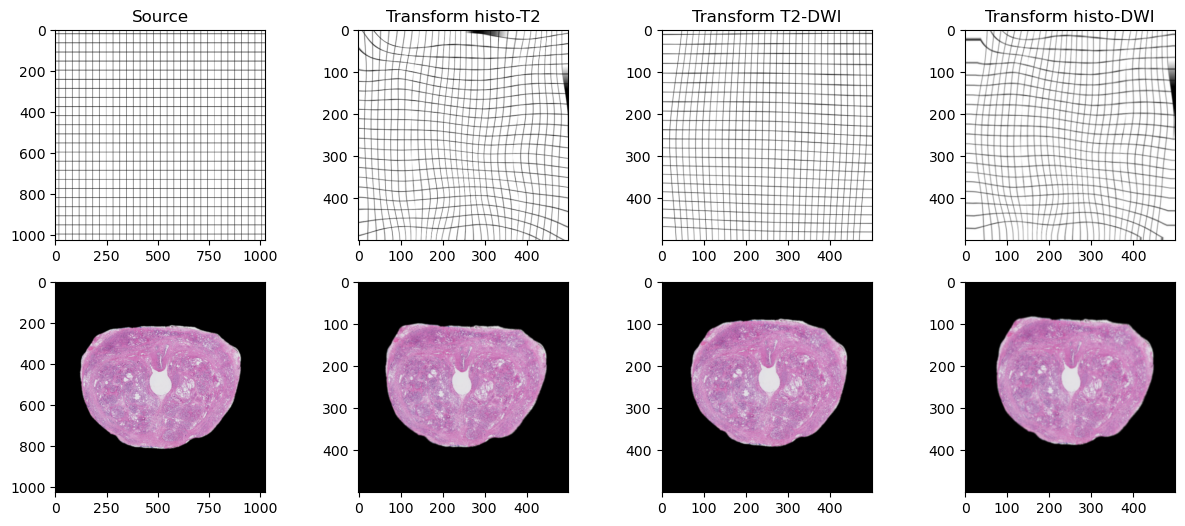

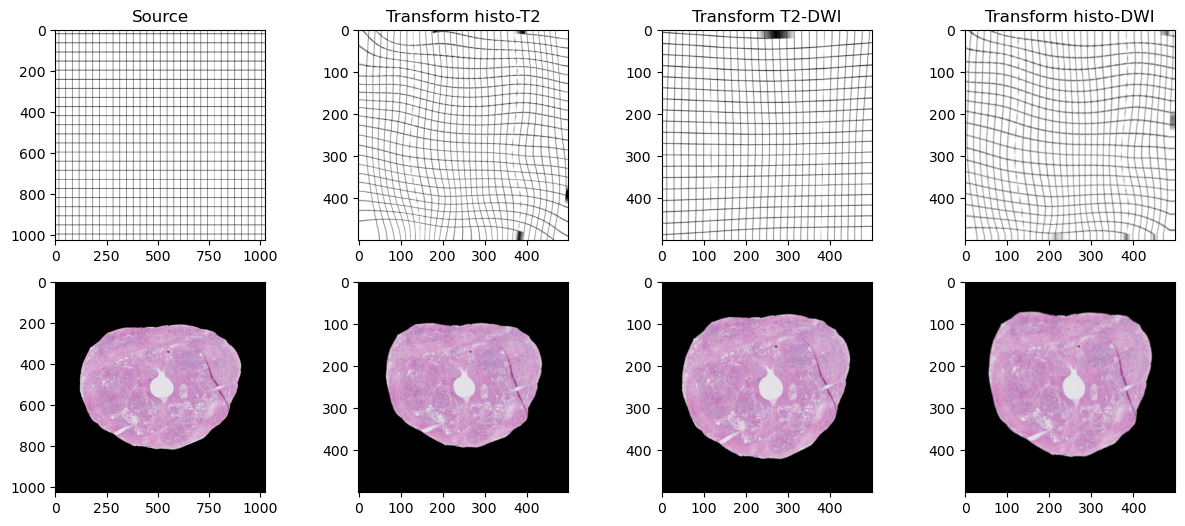

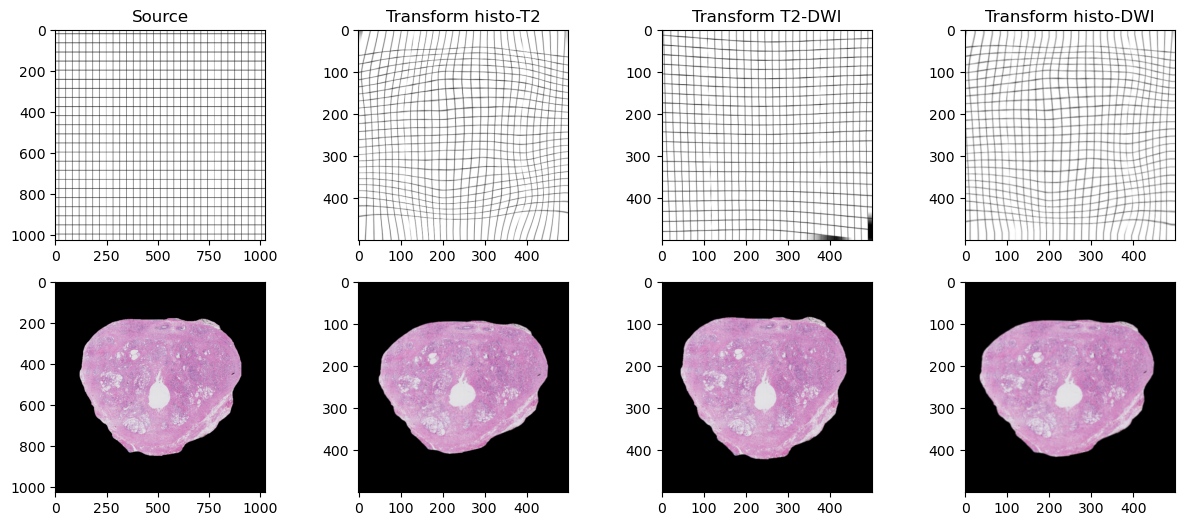

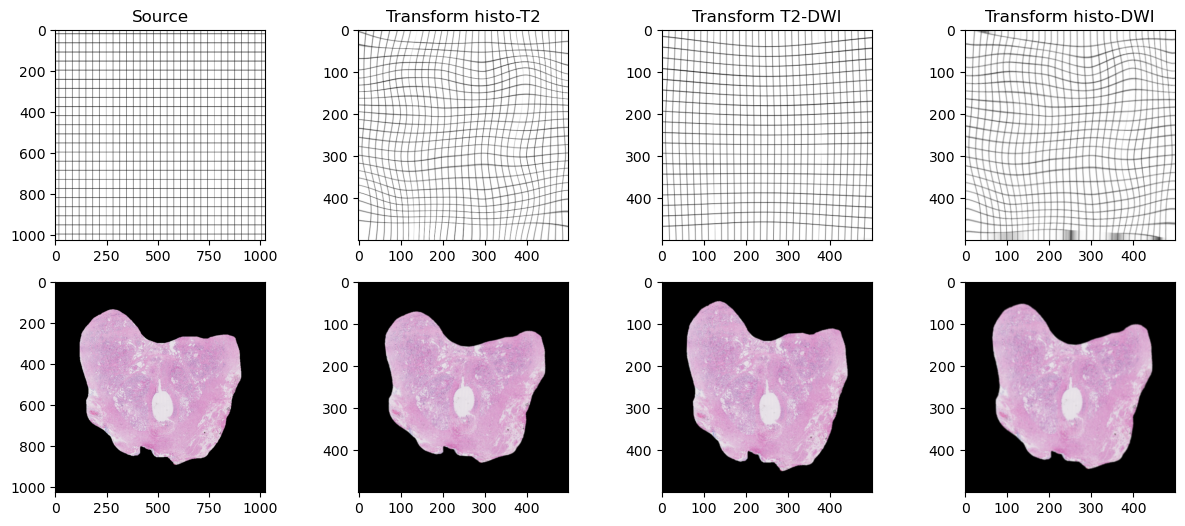

In [45]:
from transform_histo_dwi import get_data, create_tensor
from glob import glob

sid = 'HMU_010_FH'
json_path_histo_t2  = './transforms/transform_' + sid + '.json'
json_path_t2_dwi    = './transforms/transform_' + sid + '_T2_DWI.json'
img_path   = os.path.join('./results/preprocess/hist' , sid+'_high_res/')

json_data_histo_t2 = get_data(json_path_histo_t2)
json_data_t2_dwi   = get_data(json_path_t2_dwi)

# Get image paths
img_path   = os.path.join('./results/preprocess/hist' , sid)
all_paths = sorted(glob(img_path + '/hist*.png'))

# Get transformation params
for i in range(4):
    theta_aff_1 = json_data_histo_t2[str(i)]["affine_1"]
    theta_aff_2 = json_data_histo_t2[str(i)]["affine_2"]
    theta_tps_1 = json_data_histo_t2[str(i)]["tps"]
    transforms_1  = (create_tensor(theta_aff_1, use_cuda=False), create_tensor(theta_aff_2, use_cuda=False), create_tensor(theta_tps_1, use_cuda=False)) 

    theta_aff_3 = json_data_t2_dwi[str(i)]["affine_1"]
    theta_aff_4 = json_data_t2_dwi[str(i)]["affine_2"]
    theta_tps_2 = json_data_t2_dwi[str(i)]["tps"]
    transforms_2  = (create_tensor(theta_aff_3, use_cuda=False), create_tensor(theta_aff_4, use_cuda=False), create_tensor(theta_tps_2, use_cuda=False))
    
    source_img = io.imread(all_paths[i])

    tps_Grid_full(transforms_1, transforms_2, source_img)